In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt

In [3]:
db = pd.read_csv("bpi19ite.csv")

In [5]:
iteration = db.pop('iteration')

In [6]:
target = np.where(iteration.shift(1) >= 3,1,0)

In [7]:
# normalize data (this is important for model convergence)
def encode(db):
    dtypes = list(zip(db.dtypes.index, map(str, db.dtypes)))
    for k,dtype in dtypes:
        if dtype == 'object':
            db[k] = LabelEncoder().fit_transform(db[k])
    return db.astype('float')

In [8]:
data = encode(db)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data,target,train_size=0.7,shuffle=False)

In [30]:
def model_builder(hp):
  model = keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_hidden_activation4 = hp.Choice('activition', values=['relu','tanh'])
  hp_dense_activation = hp.Choice('activation', values=['softmax','sigmoid'])
  
  
  model.add(tf.keras.layers.Reshape((data.shape[1],-1),input_shape=(data.shape[1],)))
  model.add(layers.LSTM(hp_units1,return_sequences=True))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(layers.LSTM(hp_units2, return_sequences=True))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(layers.LSTM(hp_units3, return_sequences=True))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())
      
  model.add(layers.Flatten())
  model.add(layers.Dense(hp_units4, activation=hp_hidden_activation4))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(1,activation = hp_dense_activation))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [31]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='lstm')

Reloading Tuner from my_dir/lstm/tuner0.json


In [32]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [33]:
sm_train,sm_test,sy_train,sy_test = train_test_split(x_train,y_train,train_size=0.1,shuffle=False)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [34]:
tuner.search(sm_train, sy_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 26 Complete [00h 11m 43s]
val_accuracy: 0.15418699383735657

Best val_accuracy So Far: 0.9654477834701538
Total elapsed time: 01h 53m 41s


In [35]:
model_rnn= tuner.hypermodel.build(best_hps)

/home/modzo/miniconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
early = EarlyStopping(min_delta = 0.001, patience=25, restore_best_weights=True)

In [37]:
history = model_rnn.fit(x_train,y_train,
                    validation_split = 0.2,
                    batch_size=256,
                    epochs = 100,
                    callbacks=early,
                   )

Epoch 1/100
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 112s 30ms/step - accuracy: 0.9405 - loss: 0.2499 - val_accuracy: 0.9498 - val_loss: 0.1871
Epoch 2/100
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 105s 30ms/step - accuracy: 0.9520 - loss: 0.1729 - val_accuracy: 0.9460 - val_loss: 0.1776
Epoch 3/100
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 106s 30ms/step - accuracy: 0.9527 - loss: 0.1684 - val_accuracy: 0.9498 - val_loss: 0.1746
Epoch 4/100
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 106s 30ms/step - accuracy: 0.9532 - loss: 0.1656 - val_accuracy: 0.9480 - val_loss: 0.1743
Epoch 5/100
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 106s 30ms/step - accuracy: 0.9532 - loss: 0.1647 - val_accuracy: 0.9464 - val_loss: 0.1738
Epoch 6/100
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 105s 30ms/step - accuracy: 0.9540 - loss: 0.1622 - val_accuracy: 0.9469 - val_loss: 0.1778
Epoch 7/100
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 107s 31ms/step - accuracy: 0.9544 - loss: 0.1596 - val_accuracy: 0.9465 - val_loss: 0.1734
Epoch 8/100
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 97s 28ms/step - acc

In [38]:
model_rnn.save('rnn_model_optimized.h5')

In [39]:
score = model_rnn.evaluate(x_test,y_test)

14962/14962 ━━━━━━━━━━━━━━━━━━━━ 108s 7ms/step - accuracy: 0.9379 - loss: 0.1841


In [40]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.18251752853393555 / Test accuracy: 0.9391240477561951


In [42]:
history_df = pd.DataFrame(history.history)

<Axes: >

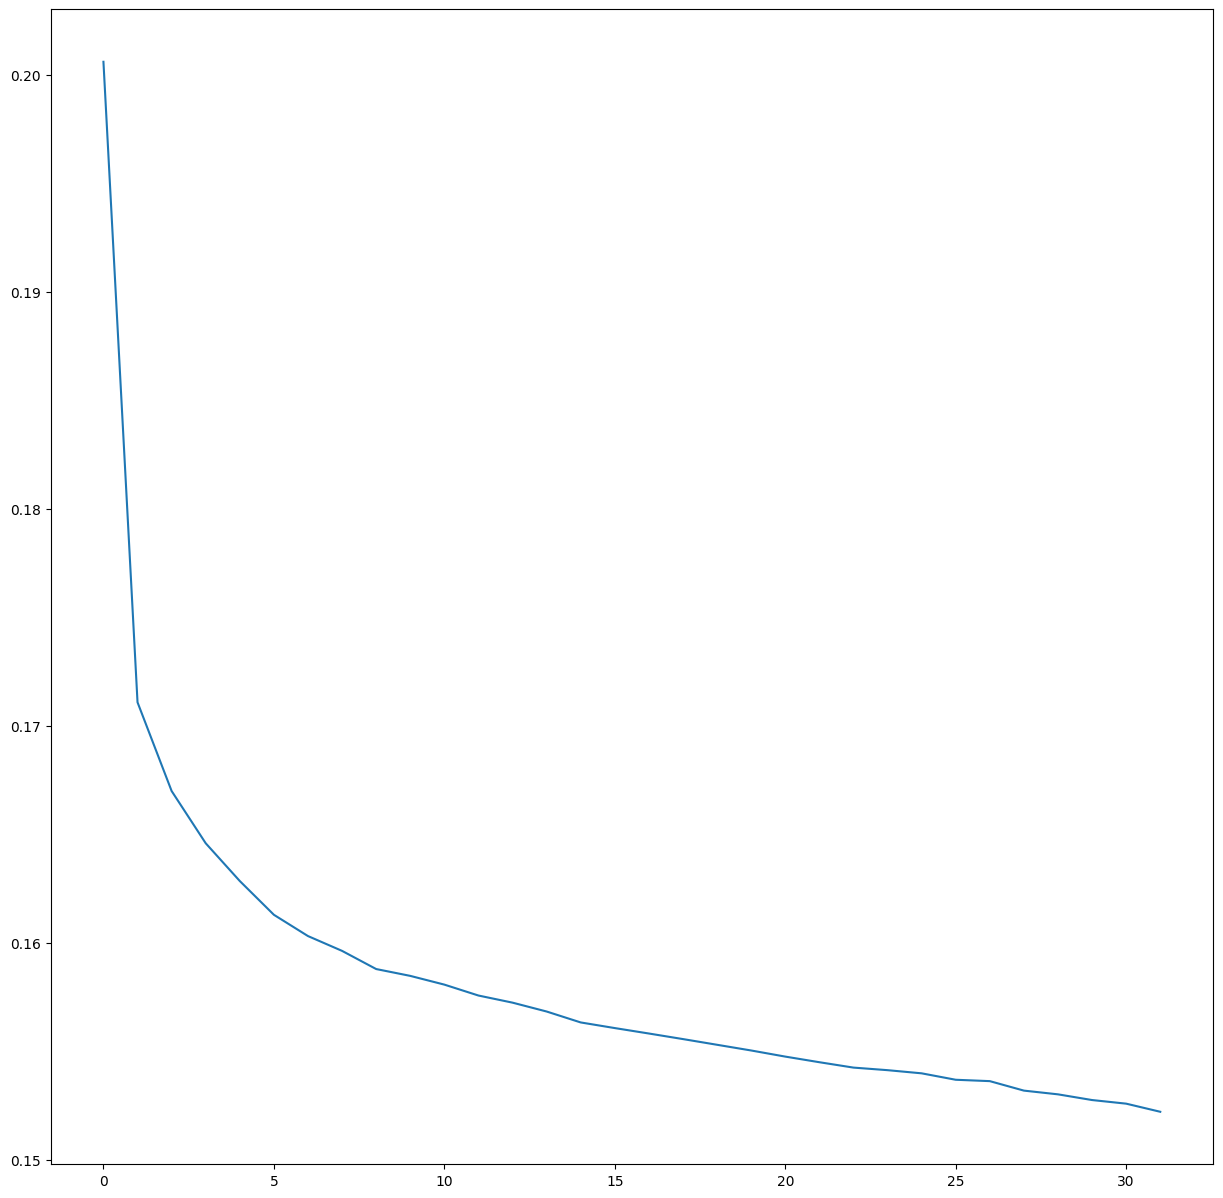

In [43]:
plt.figure(figsize=(15,15))
history_df['loss'].plot()